In [1]:
import math
import os
import torch
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
from model import StyledGenerator
import matplotlib.pyplot as plt

C:\conda\envs\face_edit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 生成图片
def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to("cpu")
        .numpy()
    )


In [3]:
# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入模型
netG = StyledGenerator(512)
netG.load_state_dict(torch.load('./checkpoints/stylegan-1024px-new.model',map_location=device)["g_running"], strict=False)
netG.eval()
netG = netG.to(device)
step = int(math.log(1024, 2)) - 2

In [5]:
def generateMix(face1_name,face2_name,mixing_range=(0,1)):
    ## 载入向量
    latent_in_1 = torch.from_numpy(np.load(face1_name + '.npy'))
    latent_in_2 = torch.from_numpy(np.load(face2_name + '.npy'))
    # 增加维度
    if len(latent_in_1.shape) == 1:
        latent_in_1 = latent_in_1.unsqueeze(0).to(device)
    if len(latent_in_2.shape) == 1:
        latent_in_2 = latent_in_2.unsqueeze(0).to(device)
        
    # 合成图片
    img_gen = netG([latent_in_1,latent_in_2], step=step,mixing_range=mixing_range)
    # 返回图片：1,1024,1024,3
    img_gen = make_image(img_gen)
    
    # 构造返回图片
    back_img = np.ones((1,1024,1024,3))*255
    
    
    # 读取原图，转为numpy格式
    face1 = np.asarray(Image.open(face1_name + '.png'))
    face1 = np.expand_dims(face1, axis=0)
    # 读取目标图，转为numpy格式
    face2 = np.asarray(Image.open(face2_name + '.png'))
    face2 = np.expand_dims(face2, axis=0)
    
    
    back_img = np.concatenate((back_img,face1),axis=0)
    back_img = np.concatenate((back_img,face2),axis=0)
    back_img = np.concatenate((back_img,img_gen),axis=0)
    
    back_img = back_img.astype('int')
    
    
    fig = plt.figure(figsize=(6, 6))

    # 背景
    plt.subplot(2, 2, 1)
    plt.imshow(back_img[0])
    plt.axis('off')  
    # 源
    plt.subplot(2, 2, 2)
    plt.imshow(back_img[1])
    plt.axis('off')
    # 目标
    plt.subplot(2, 2, 3)
    plt.imshow(back_img[2])
    plt.axis('off')
    # 合成
    plt.subplot(2, 2, 4)
    plt.imshow(back_img[3])
    plt.axis('off')

    plt.tight_layout()

    



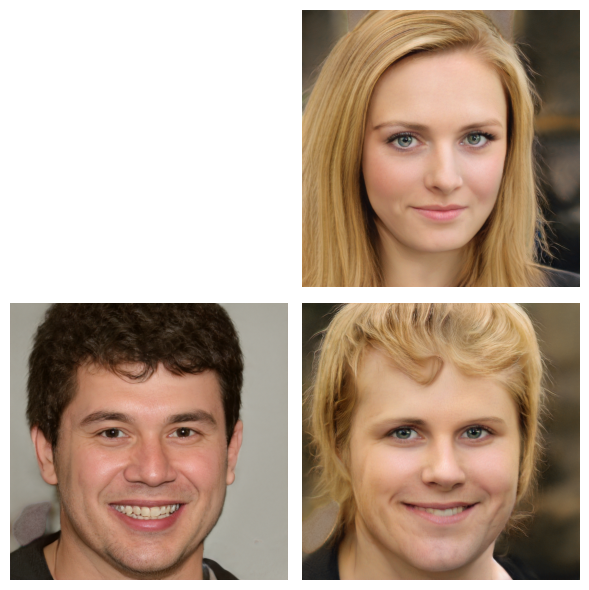

In [12]:
# 粗粒度
generateMix('./latents/z/fake3','./latents/z/fake2',(0,1))

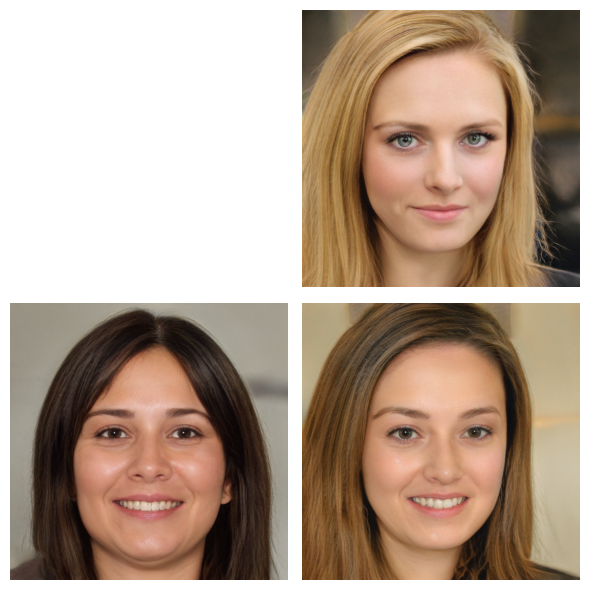

In [7]:
# 中粒度
generateMix('./latents/z/fake3','./latents/z/fake1',(2,3))

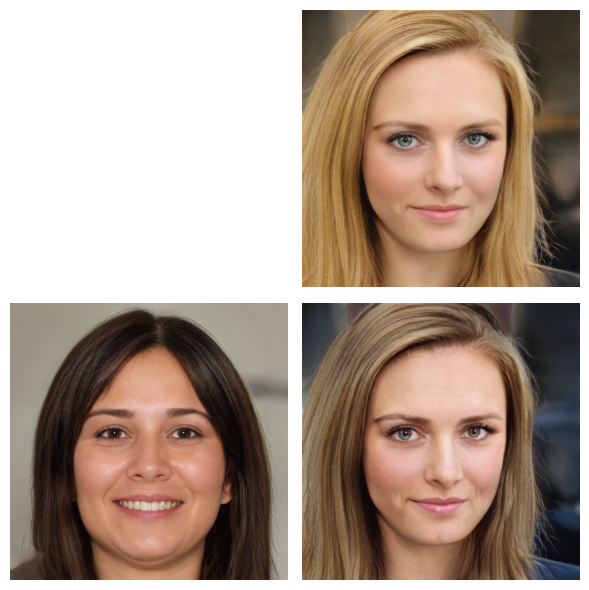

In [10]:
# 细粒度
generateMix('./latents/z/fake3','./latents/z/fake1',(4,8))